<a href="https://colab.research.google.com/github/Aman56/grok/blob/main/parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Parity learning simulations

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n = 40 # string dimension
k = 3 # parity dimension
N = 1000 # #samples
B = 32 # batch size
lr = 0.1 # learning rate

# Data generation
def parity(n, k, samples, seed=42):

  random.seed(seed)
  input = torch.Tensor([[random.choice([-1, 1]) for j in range(n)] for i in range(samples)])
  # target = torch.prod(input[:, n//2:n//2+k], dim=1) # parity hidden in the middle
  target = torch.prod(input[:, :k], dim=1) # parity hidden in first k bits

  return input, target


class FF1(torch.nn.Module):
    def __init__(self, width=1000):
      super(FF1, self).__init__()
      self.linear1 = torch.nn.Linear(n, width)
      self.activation = torch.nn.ReLU()
      self.linear2 = torch.nn.Linear(width, 1, bias=False)

    def forward(self, x):
      x = self.linear1(x)
      x = self.activation(x)
      x = self.linear2(x)
      return x

    def masked_forward(self, x, mask):
      x = self.linear1(x)
      x = self.activation(x)
      x = x * mask
      x = self.linear2(x)
      return x


class MyHingeLoss(torch.nn.Module):
  def __init__(self):
    super(MyHingeLoss, self).__init__()

  def forward(self, output, target):
    hinge_loss = 1 - torch.mul(torch.squeeze(output), torch.squeeze(target))
    hinge_loss[hinge_loss < 0] = 0
    return hinge_loss

loss_fn = MyHingeLoss()

In [2]:
from torch.utils.data import TensorDataset, DataLoader
data = parity(n, k, N)
train_dataset = TensorDataset(data[0], data[1])
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

data = parity(n, k, 100, seed=101) # test samples
test_dataset = TensorDataset(data[0], data[1])
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [35]:
import matplotlib.pyplot as plt

T = 200 # epochs
reg_lambda = 0.01

def acc_calc(dataloader, model, mask_idx=None):
  acc = 0
  for id, (x_batch, y_batch) in enumerate(dataloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    if (mask_idx is not None):
      # create mask
      idx = torch.LongTensor([mask_idx for _ in range(len(y_batch))])
      mask = torch.zeros(len(y_batch), 1000)
      mask.scatter_(1, idx, 1.)

      pred = model.masked_forward(x_batch, mask.to(device))
    else:
      pred = model(x_batch)
    acc += (torch.sign(torch.squeeze(pred)) == y_batch).sum().item()

  if (id > 0):
    return acc / N # train set
  else:
    return acc / x_batch.shape[0] # test set

def loss_calc(dataloader, model):
  loss = 0
  for id, (x_batch, y_batch) in enumerate(dataloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

    pred = model(x_batch)
    loss += loss_fn(pred, y_batch).sum().item()

  if (id > 0):
    return loss / N # train set
  else:
    return loss / x_batch.shape[0] # test set

num_seeds = 1
mem_PATH, gen_PATH = 'memorization.pt', 'generalization.pt'
mem_epoch, gen_epoch = -1, -1
for seed_id in range(num_seeds):
  torch.manual_seed(seed_id)
  # print(seed_id)
  model = FF1()
  model = model.to(device)
  
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=reg_lambda)


  train_loss, test_loss = [], []
  train_acc, test_acc = [], []
  norms = {'feats':  [],
           'conx':  []}
  for epoch in range(T):
    if (epoch % 100 == 0):
      print(f"Epoch {epoch + 1}\n-------------------------------")

    norms['feats'].append(torch.linalg.norm(list(model.parameters())[0], dim=1).detach().cpu().numpy())
    norms['conx'].append(torch.squeeze(list(model.parameters())[2]).detach().cpu().numpy())
    train_loss.append(loss_calc(train_dataloader, model))
    test_loss.append(loss_calc(test_dataloader, model))

    train_acc.append(acc_calc(train_dataloader, model))
    test_acc.append(acc_calc(test_dataloader, model))

    if (train_acc[-1] > 0.98 and mem_epoch < 0):
      print(f'Saving memorizing model - epoch {epoch}')
      torch.save(model.state_dict(), mem_PATH)
      mem_epoch = epoch
    if (test_acc[-1] > 0.98 and gen_epoch < 0):
      print(f'Saving generalizing model - epoch {epoch}')
      torch.save(model.state_dict(), gen_PATH)
      gen_epoch = epoch
    torch.save(model.state_dict(), f'model_{epoch}.pt')
    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      pred = model(x_batch)

      optimizer.zero_grad()
      loss = loss_fn(pred, y_batch).mean()
      loss.backward()
      optimizer.step()

Epoch 1
-------------------------------
Saving memorizing model - epoch 25
Epoch 101
-------------------------------
Saving generalizing model - epoch 137


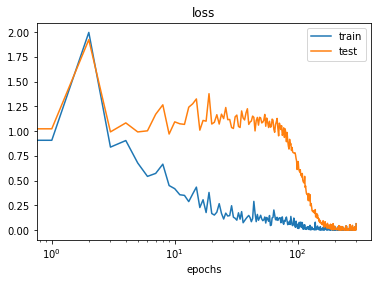

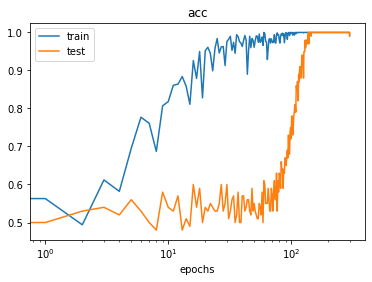

In [5]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('loss')
plt.xlabel('epochs')
plt.xscale('log')
plt.legend()
plt.show()


plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('acc')
plt.xlabel('epochs')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
for k in [0, 20, 50, 80, 120]:
  plt.hist(norms['feats'][k], bins=len(norms['feats'][k]))
  plt.title(f'Epoch {k}')
  plt.show()

700 254


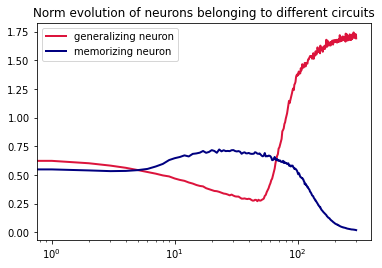

In [7]:
best = norms['feats'][gen_epoch].argmax()
prev_best = norms['feats'][mem_epoch].argmax()
print(best, prev_best)

traj, prev_traj = [], []
for k in range(T):
  traj.append(norms['feats'][k][best])
  prev_traj.append(norms['feats'][k][prev_best])

plt.plot(traj, label='generalizing neuron', lw=2, color='crimson')
plt.plot(prev_traj, label='memorizing neuron', lw=2, color='navy')
plt.title('Norm evolution of neurons belonging to different circuits')
plt.xscale('log')
plt.legend()
plt.show()

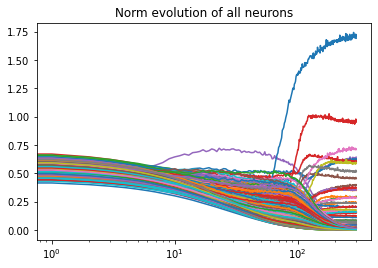

In [8]:
import numpy as np

trajs = []
for neuron in range(1000):
  trajs.append([])
  for k in range(T):
    trajs[-1].append(norms['feats'][k][neuron])

sorted_idx = np.array(norms['feats'][-1]).argsort()
for neuron in range(1000):
  plt.plot(trajs[neuron])
  plt.title('Norm evolution of all neurons')
  plt.xscale('log')
plt.show()

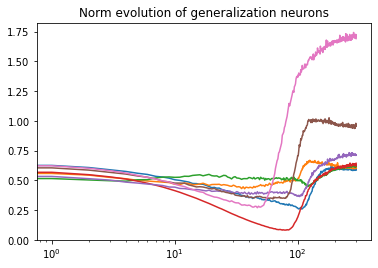

In [9]:
top_k = 7
gen_idx = np.array(norms['feats'][-1]).argsort()[-top_k:]

trajs = []
for neuron in list(gen_idx):
  trajs.append([])
  for k in range(T):
    trajs[-1].append(norms['feats'][k][neuron])

for neuron in range(len(list(gen_idx))):
  plt.plot(trajs[neuron])
  plt.title('Norm evolution of generalization neurons')
  plt.xscale('log')
plt.show()

### Sub circuit discovery

In [15]:
def circuit_discovery(saved_model, epoch):
  # Calculate least number of neurons that recovers original (train set) performance
  for k in range(1, 1000):
    idx = np.array(norms['feats'][epoch]).argsort()[-k:]

    if (acc_calc(train_dataloader, saved_model, idx) == acc_calc(train_dataloader, saved_model)):
      print(f'Model in epoch {epoch} has {k} active neurons')
      return idx
      
    # acc_calc(train_dataloader, mem_model)

gen_model = FF1().to(device)
gen_model.load_state_dict(torch.load(gen_PATH))
gen_idx = circuit_discovery(gen_model, gen_epoch)

mem_model = FF1().to(device)
mem_model.load_state_dict(torch.load(mem_PATH))
mem_idx = circuit_discovery(mem_model, mem_epoch)

Model in epoch 137 has 9 active neurons
Model in epoch 25 has 711 active neurons


### Saturation of subcircuit

In [26]:
"""Utilities for working with saturated models."""

from typing import Union, Iterable
import torch
from torch.nn import Module, Parameter

# def extract_prediction(x):
#     return torch.squeeze(x[:, -2, :])

def return_mask(mask_idx, length):

  idx = torch.LongTensor([mask_idx for _ in range(length)])
  mask = torch.zeros(length, 1000)
  mask.scatter_(1, idx, 1.)
  return mask.to(device)


def _identity(x):
    return x


def get_saturation(module, *args, **kwargs):
    """Get the saturation scores of a model over a dataset that can be specified through `*args, **kwargs`.

    Note that `module` should return a [batch_size, feature_dim] vector, or `extract_fn` should format its output this way.
    """

    extract_fn = _identity
    infinity = 1000

    module.eval()
    for (x, _) in args[0]:
        x = x.to(device)
        mask = return_mask(kwargs['idx'], x.shape[0])
        with saturate(module, infinity=infinity):
            hard_outputs = module.masked_forward(x, mask)
            hard_vector = extract_fn(hard_outputs)
        soft_outputs = module.masked_forward(x, mask)
        soft_vector = extract_fn(soft_outputs)

        inner_prods = torch.einsum("bi, bi -> b", hard_vector, soft_vector)
        soft_norm = soft_vector.norm(p=2, dim=1)
        hard_norm = hard_vector.norm(p=2, dim=1)
        # Add 1e-9 for numerical stability.
        scores = inner_prods / (soft_norm * hard_norm + 1e-9)
    
    return scores.mean()


class saturate:

    """Context manager in which a model's parameters and forward pass will be saturated.
    We can pass in either a torch module or an iterable of torch parameters to saturated. Gradients will be disabled.

    Example usage:

    ```python
    with saturate(model):
        outputs = model(inputs)
    ```
    """

    def __init__(
        self,
        model_or_params: Union[Module, Iterable[Parameter]],
        infinity: float = 1000,
        no_grad: bool = True,
    ):
        if isinstance(model_or_params, Module):
            self.params = model_or_params.parameters()
        else:
            self.params = model_or_params

        self.params = list(self.params)
        self.infinity = infinity
        self.old_param_data = []
        self.no_grad = torch.no_grad() if no_grad else None

    def __enter__(self):
        if self.no_grad:
            self.no_grad.__enter__()
        for param in self.params:
            self.old_param_data.append(param.data)
            param.data = param.data.mul(self.infinity)

    def __exit__(self, type, value, traceback):
        for param, data in zip(self.params, self.old_param_data):
            param.data = data
        if self.no_grad:
            self.no_grad.__exit__(type, value, traceback)


class masked_saturate:
    def __init__(
        self,
        params: Iterable[Parameter],
        masks: Iterable[Parameter],
        infinity: float = 1000,
    ):
        self.params = list(params)
        self.masks = masks
        self.infinity = infinity
        self.old_param_data = []
        self.no_grad = torch.no_grad()

    def __enter__(self):
        self.no_grad.__enter__()
        for param, mask in zip(self.params, self.masks):
            self.old_param_data.append(param.data)
            param.data = torch.where(mask, param.data.mul(self.infinity), param.data)

    def __exit__(self, type, value, traceback):
        for param, data in zip(self.params, self.old_param_data):
            param.data = data
        self.no_grad.__exit__(type, value, traceback)


In [33]:
gen_saturation = get_saturation(gen_model, train_dataloader, idx=gen_idx)
mem_saturation = get_saturation(mem_model, train_dataloader, idx=mem_idx)

In [34]:
print('Saturation of generalizing circuit:', gen_saturation)
print('Saturation of memorizing circuit:', mem_saturation)

Saturation of generalizing circuit: tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)
Saturation of memorizing circuit: tensor(1., device='cuda:0', grad_fn=<MeanBackward0>)


### Saturation over time

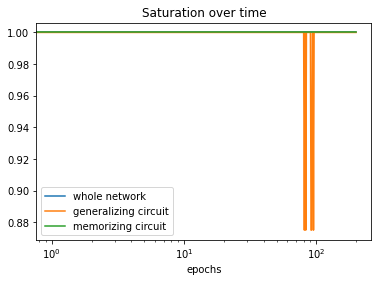

In [47]:
global_saturation, gen_saturation, mem_saturation = [], [], []
for epoch in range(T):
  _model = FF1().to(device)
  _model.load_state_dict(torch.load(f'model_{epoch}.pt'))

  _saturation = get_saturation(_model, train_dataloader, idx=np.array([i for i in range(1000)]))
  global_saturation.append(_saturation.item())

  _saturation = get_saturation(_model, train_dataloader, idx=gen_idx)
  gen_saturation.append(_saturation.item())

  _saturation = get_saturation(_model, train_dataloader, idx=mem_idx)
  mem_saturation.append(_saturation.item())

plt.plot(global_saturation, label='whole network')
plt.plot(gen_saturation, label='generalizing circuit')
plt.plot(mem_saturation, label='memorizing circuit')
plt.legend()
plt.xscale('log')
plt.xlabel('epochs')
plt.title('Saturation over time')
plt.savefig('saturation_parity.pdf')
plt.show()